# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir models/

In [3]:
!pip3 install pyidaungsu
!pip3 install torchdata
!pip3 install torchtext
!pip3 install portalocker
!pip3 install datasets
!pip3 install spacy
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199775 sha256=73998c0260c3d946690a9fdf25ff2d372cea62ccc7154c70aa5f990d008d9cff
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
INF

In [4]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F
import pyidaungsu as pds

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [5]:
# torch.cuda.get_device_name(0)

In [6]:
torch.__version__

'2.1.0+cu121'

In [7]:
torchtext.__version__

'0.16.0+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [8]:
import torchtext, datasets

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))
dataset = datasets.load_dataset('myothiha/mm_eng_alt_corpus')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [9]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [10]:
train = [(row['en'], row['my']) for row in dataset['train']]

In [11]:
train[0]

('She feels that "it could be Taposiris Magna because it was the most sacred temple of its time."',
 '" ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။')

## 2. EDA - simple investigation

In [12]:
#let's take a look at one example of train
sample = train[0]
sample

('She feels that "it could be Taposiris Magna because it was the most sacred temple of its time."',
 '" ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။')

In [13]:
train_size = len(train)
train_size

16280

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [14]:
# train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)
val = [(row['en'], row['my']) for row in dataset['validation']]
test = [(row['en'], row['my']) for row in dataset['test']]

In [15]:
train_size = len(train)
train_size

16280

In [16]:
val_size = len(val)
val_size

1809

In [17]:
test_size = len(test)
test_size

2010

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [18]:
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download de_core_news_sm

In [19]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [20]:
# Myanmar word tokenizer.
def mmtokenizer(sentence):
    return pds.tokenize(sentence, form="word")

In [21]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = mmtokenizer

In [22]:
sample

('She feels that "it could be Taposiris Magna because it was the most sacred temple of its time."',
 '" ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။')

In [23]:
#example of tokenization of the english part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  " ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။
Tokenization:  ['"', 'ဒီ', 'ဟာ', 'သည်', 'အဲ့ဒီ', 'အချိန်', 'တုန်း', 'က', 'လက်ရာ', 'အမြောက်ဆုံး', 'ဖြစ်', 'တာ', 'ကြောင့်', 'တာ', 'ပို', 'ဆာရစ်မက်နဘုရား', 'ကျောင်း', 'ဖြစ်', 'လိမ့်', 'မယ်', 'လို့', '"', 'သူ', 'မ', 'ခံစား', 'ရ', 'ပါ', 'သည်', '။']


A function to tokenize our input.

In [24]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [25]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [26]:
next(iter(train))

('She feels that "it could be Taposiris Magna because it was the most sacred temple of its time."',
 '" ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။')

In [27]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #The minimum frequency needed to include a token in the vocabulary. if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [28]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[795, 18, 12, 0, 12]

In [29]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'vessel'

In [30]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [31]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [32]:
#check unique vocabularies
len(mapping)

16009

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [33]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 512

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], # Tokenization
                                               vocab_transform[ln], # Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [34]:
batch_size = 512

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [35]:
# for en, len, de in train_loader:
#     break

# print(en[1])
# print(len[1])
# print(de[1])

Let's test the train loader.

In [36]:
for en, _, de in train_loader:
    break

In [37]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("German shape: ", de.shape)   # (batch_size, seq len)

English shape:  torch.Size([512, 68])
German shape:  torch.Size([512, 104])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [40]:
# MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
# forward(src, src, src, src_mask)
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        # General
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention


### Position-wise Feedforward Layer

In [41]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [42]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [43]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 500):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [44]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [45]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [46]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              enc_dropout,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16009, 256)
    (pos_embedding): Embedding(500, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
  

In [47]:
# input_dim   = len(vocab_transform[SRC_LANGUAGE])
# output_dim  = len(vocab_transform[TRG_LANGUAGE])
# hid_dim = 256
# enc_layers = 3
# dec_layers = 3
# enc_heads = 8
# dec_heads = 8
# enc_pf_dim = 512
# dec_pf_dim = 512
# enc_dropout = 0.1
# dec_dropout = 0.1

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

# enc = Encoder(input_dim,
#             hid_dim,
#             enc_layers,
#             enc_heads,
#             enc_pf_dim,
#             enc_dropout,
#             device)

# dec = Decoder(output_dim,
#             hid_dim,
#             dec_layers,
#             dec_heads,
#             dec_pf_dim,
#             enc_dropout,
#             device)

# model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model.apply(initialize_weights)

In [48]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

4098304
128000
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3153408
128000
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
3153408
 12318
______
14627102


In [49]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [50]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [51]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [52]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [53]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [54]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}-general.pt'
model_name = f'{model.__class__.__name__}-general.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

Epoch: 01 | Time: 1m 2s
	Train Loss: 7.443 | Train PPL: 1708.175
	 Val. Loss: 6.027 |  Val. PPL: 414.525
Epoch: 02 | Time: 1m 0s
	Train Loss: 5.806 | Train PPL: 332.189
	 Val. Loss: 5.243 |  Val. PPL: 189.249
Epoch: 03 | Time: 1m 0s
	Train Loss: 5.092 | Train PPL: 162.703
	 Val. Loss: 4.739 |  Val. PPL: 114.291
Epoch: 04 | Time: 1m 0s
	Train Loss: 4.676 | Train PPL: 107.303
	 Val. Loss: 4.503 |  Val. PPL:  90.257
Epoch: 05 | Time: 1m 0s
	Train Loss: 4.409 | Train PPL:  82.210
	 Val. Loss: 4.359 |  Val. PPL:  78.201
Epoch: 06 | Time: 1m 0s
	Train Loss: 4.193 | Train PPL:  66.192
	 Val. Loss: 4.271 |  Val. PPL:  71.587
Epoch: 07 | Time: 1m 0s
	Train Loss: 4.005 | Train PPL:  54.845
	 Val. Loss: 4.206 |  Val. PPL:  67.080
Epoch: 08 | Time: 1m 0s
	Train Loss: 3.832 | Train PPL:  46.168
	 Val. Loss: 4.159 |  Val. PPL:  63.977
Epoch: 09 | Time: 1m 0s
	Train Loss: 3.676 | Train PPL:  39.506
	 Val. Loss: 4.139 |  Val. PPL:  62.740
Epoch: 10 | Time: 1m 0s
	Train Loss: 3.531 | Train PPL:  34.171

Text(0, 0.5, 'loss')

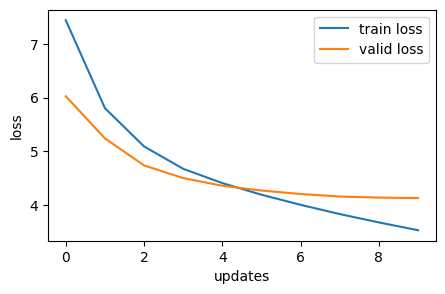

In [55]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [56]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.099 | Test PPL:  60.289 |


In [57]:
import pickle

meta = {
    'token_transform': token_transform,
    'vocab_transform': vocab_transform,
}
meta_name = 'meta-general.pkl'
pickle.dump(meta, open('models/meta-general.pkl', 'wb'))

## 7. Test on some random news

In [58]:
sample[0]

'She feels that "it could be Taposiris Magna because it was the most sacred temple of its time."'

In [59]:
sample[1]

'" ဒီဟာ သည် အဲ့ဒီ အချိန်တုန်း က လက်ရာအမြောက်ဆုံး ဖြစ်တာ ကြောင့် တာပိုဆာရစ် မက်န ဘုရားကျောင်း ဖြစ်လိမ့်မယ် လို့ " သူမ ခံစားရပါသည် ။'

In [60]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([    2,   323,  7304,    13,    11,    32,    93,    29,     0,     0,
          125,    32,    16,     4,   145, 11286,  2562,     7,    60,    64,
            6,    11,     3], device='cuda:0')

In [61]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   34,   77,   93,    4, 1013,  123, 1454,   11, 2755,    0,   19,
          84,   95,   84,  152,    0,  210,   19,   52,  212,   73,   34,   15,
          26,  338,   30,   23,    4,    8,    3], device='cuda:0')

In [62]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [63]:
trg_text = trg_text.reshape(1, -1)

In [64]:
src_text.shape, trg_text.shape

(torch.Size([1, 23]), torch.Size([1, 31]))

In [65]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [66]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [67]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 31, 12318])

Since batch size is 1, we just take off that dimension

In [68]:
output = output.squeeze(0)

In [69]:
output.shape

torch.Size([31, 12318])

We shall remove the first token since it's zeroes anyway

In [70]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([30, 12318])

Then we just take the top token with highest probabilities

In [71]:
output_max = output.argmax(1) #returns max indices

In [72]:
output_max

tensor([135,  93,   0,   0, 123,  31,  11,   0,  53,  19,  23,  19,  19,  19,
        198,  19,  19,  23, 212,  73,  15,  73,  26, 236,  30,  23,  39,   8,
          3,  19], device='cuda:0')

Get the mapping of the target language

In [73]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [74]:
for token in output_max:
    print(mapping[token.item()])

သူမ
ဟာ
<unk>
<unk>
အချိန်
မှာ
က
<unk>
တွေ
ဖြစ်
ပါ
ဖြစ်
ဖြစ်
ဖြစ်
ကောင်း
ဖြစ်
ဖြစ်
ပါ
မယ်
လို့
သူ
လို့
မ
သိ
ရ
ပါ
တယ်
။
<eos>
ဖြစ်


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [75]:
attentions.shape

torch.Size([1, 8, 31, 23])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [76]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([31, 23])

In [77]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'She',
 'feels',
 'that',
 '"',
 'it',
 'could',
 'be',
 'Taposiris',
 'Magna',
 'because',
 'it',
 'was',
 'the',
 'most',
 'sacred',
 'temple',
 'of',
 'its',
 'time',
 '.',
 '"',
 '<eos>']

In [78]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'သူမ',
 'ဟာ',
 '<unk>',
 '<unk>',
 'အချိန်',
 'မှာ',
 'က',
 '<unk>',
 'တွေ',
 'ဖြစ်',
 'ပါ',
 'ဖြစ်',
 'ဖြစ်',
 'ဖြစ်',
 'ကောင်း',
 'ဖြစ်',
 'ဖြစ်',
 'ပါ',
 'မယ်',
 'လို့',
 'သူ',
 'လို့',
 'မ',
 'သိ',
 'ရ',
 'ပါ',
 'တယ်',
 '။',
 '<eos>',
 'ဖြစ်']

In [79]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-79-08ff35c238c4>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-79-08ff35c238c4>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4126 (\N{MYANMAR LETTER SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4144 (\N{MYANMAR VOWEL SIGN UU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4121 (\N{MYANMAR LETTER MA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4127 (\N{MYANMAR LETTER HA}) missing from c

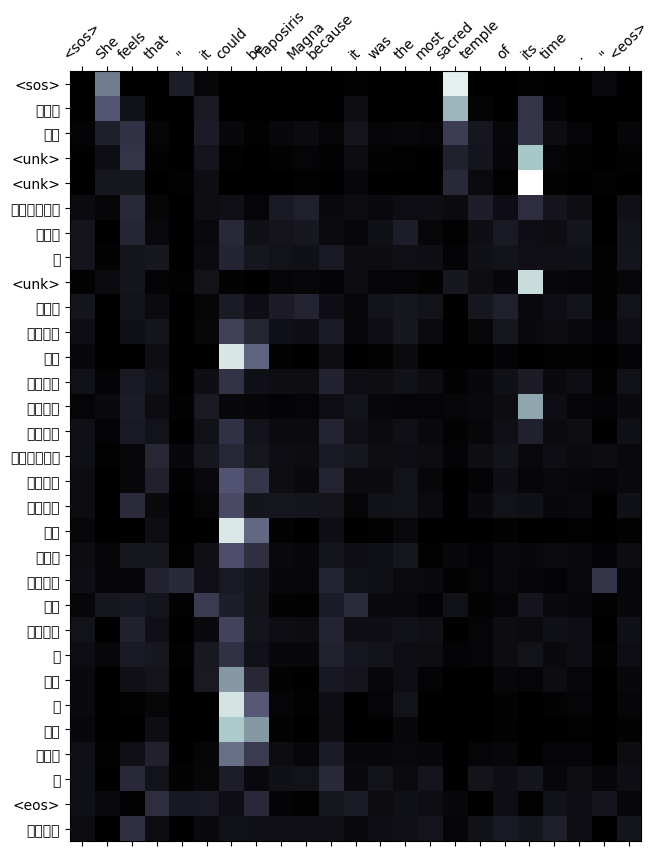

In [80]:
display_attention(src_tokens, trg_tokens, attention)

In [81]:
dest = "/content/drive/MyDrive/Colab_Notebooks/NLP/Assignment3/models"

In [82]:
!cp -R models/$model_name $dest

In [83]:
!cp -R models/$meta_name $dest